# Get Statistics on Existing Data

Before we proceed with conversion of the data to a format that can be used by the NoSketch Engine let's first get some statistics on the existing data. This will help us understand the data better and also help us in making decisions on how to proceed with the data conversion.

In [26]:
from pathlib import Path
import zipfile
from collections import defaultdict
import pandas as pd

# Defining the source and output folders
src_zip_folder = Path(r"I:\zips")  # Specify the source folder
csv_output_folder = Path(r"I:\csv")  # Specify the output folder for CSV
xlsx_output_folder = Path(r"I:\xlsx")  # Specify the output folder for Excel files
#txt_output_folder = Path(r"I:\txt")  # Specify the output folder for TXT files

def get_zip_stats(src_zip: str | Path, suffixes=("_ocr.xml", "_alto.xml")) -> dict:
    zip_stats_dict = {
        "number_of_first_level_folders": 0,
        "number_of_files_across_all_folders": 0,
        "total_size_mb": 0.0,  # Total size in MB
        "largest_file_mb": (None, 0.0),  # (file name, size in MB)
        "smallest_file_kb": (None, float('inf')),  # (file name, size in KB)
        "files_with_no_extension": 0,  # Count of files without extensions
        "common_extensions": defaultdict(int),
    }

    # Optional suffix counts
    suffix_counts = {suffix.replace('.', '_'): 0 for suffix in suffixes}
    
    try:
        with zipfile.ZipFile(src_zip, 'r') as zip_ref:
            # List to keep track of first-level folders
            first_level_folders = set()
            for file_info in zip_ref.infolist():
                # Skip directories (which have a file_size of 0)
                if file_info.is_dir():
                    continue

                # Count the number of first-level folders
                if '/' in file_info.filename:
                    first_folder = file_info.filename.split('/')[0]
                    first_level_folders.add(first_folder)

                # Count total files and sizes
                zip_stats_dict["number_of_files_across_all_folders"] += 1
                file_size_mb = round(file_info.file_size / (1024 * 1024), 3)  # Convert bytes to MB and round to 3 decimal places
                file_size_kb = round(file_info.file_size / 1024, 2)  # Convert bytes to KB and round to 2 decimal places
                zip_stats_dict["total_size_mb"] = round(zip_stats_dict["total_size_mb"] + file_size_mb, 3)  # Accumulate and round to 3 decimal places

                # Check for largest and smallest files
                if file_size_mb > zip_stats_dict["largest_file_mb"][1]:
                    zip_stats_dict["largest_file_mb"] = (Path(file_info.filename).name, file_size_mb)  # Only the file name
                if file_size_kb < zip_stats_dict["smallest_file_kb"][1]:
                    zip_stats_dict["smallest_file_kb"] = (Path(file_info.filename).name, file_size_kb)  # Only the file name

                # Check for files without an extension
                if '.' not in Path(file_info.filename).name:
                    zip_stats_dict["files_with_no_extension"] += 1  # Increment count if there is no extension

                # Count common extensions
                extension = Path(file_info.filename).suffix
                if extension:
                    zip_stats_dict["common_extensions"][extension] += 1
                
                # Count specific suffixes
                for suffix in suffixes:
                    if file_info.filename.endswith(suffix):
                        suffix_counts[suffix.replace('.', '_')] += 1

            # Update the statistics dictionary
            zip_stats_dict["number_of_first_level_folders"] = len(first_level_folders)
            zip_stats_dict.update(suffix_counts)

    except zipfile.BadZipFile:
        print(f"The file {src_zip} is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred while processing {src_zip}: {e}")

    # Convert common_extensions to a list of tuples and sort it
    zip_stats_dict["common_extensions"] = sorted(zip_stats_dict["common_extensions"].items(), key=lambda x: x[1], reverse=True)
    
    return zip_stats_dict


def process_all_zips_and_save_stats(src_folder: Path):
    all_zip_stats = []
    
    # Process each zip file in the source folder
    for zip_file in src_folder.glob("*.zip"):
        zip_stats = get_zip_stats(zip_file)
        all_zip_stats.append({
            "main_folder": zip_file.parent.name,  # Only store the full name of the main folder
            "file name": zip_file.name,  # Only store the zip file name
            **zip_stats  # Include the stats from the zip file
        })
    
    # Create a DataFrame from the collected stats
    df_zip = pd.DataFrame(all_zip_stats)

    # Define output CSV and Excel file paths
    output_csv_zip = csv_output_folder / "zip_folder_stats.csv"
    output_excel_zip = xlsx_output_folder / "zip_folder_stats.xlsx"
    
    # Save DataFrame to CSV with ';' as separator and avoid subfolders in filenames
    df_zip.to_csv(output_csv_zip, sep=';', index=False, encoding='utf-8-sig')
    
    # Save DataFrame to Excel
    df_zip.to_excel(output_excel_zip, index=False, engine='openpyxl')
    
    print(f"Statistics saved to {output_csv_zip} and {output_excel_zip}")

# Example usage:
if __name__ == "__main__":
    process_all_zips_and_save_stats(src_zip_folder)


Statistics saved to I:\csv\zip_folder_stats.csv and I:\xlsx\zip_folder_stats.xlsx


In [30]:
from pathlib import Path
import zipfile
from collections import defaultdict
import pandas as pd

# Defining the source and output folders
src_zip_folder = Path(r"I:\zips")  # Specify the source folder
csv_output_folder = Path(r"I:\csv")  # Specify the output folder for CSV
xlsx_output_folder = Path(r"I:\xlsx")  # Specify the output folder for Excel files

def get_zip_stats(src_zip: str | Path, suffixes=("_ocr.xml", "_alto.xml")) -> dict:
    zip_stats_dict = {
        "number_of_first_level_folders": 0,
        "number_of_files_across_all_folders": 0,
        "total_size_mb": 0.0,
        "largest_file": (None, 0.0),
        "largest_file_size_mb": 0.0,
        "smallest_file": (None, float('inf')),
        "smallest_file_size_kb": float('inf'),
        "files_with_no_extension": 0,
        "common_extensions": defaultdict(int),
    }

    suffix_counts = {suffix.replace('.', '_'): 0 for suffix in suffixes}

    try:
        with zipfile.ZipFile(src_zip, 'r') as zip_ref:
            first_level_folders = set()
            for file_info in zip_ref.infolist():
                if file_info.is_dir():
                    continue

                if '/' in file_info.filename:
                    first_folder = file_info.filename.split('/')[0]
                    first_level_folders.add(first_folder)

                zip_stats_dict["number_of_files_across_all_folders"] += 1
                file_size_mb = round(file_info.file_size / (1024 * 1024), 3)
                file_size_kb = round(file_info.file_size / 1024, 2)
                zip_stats_dict["total_size_mb"] = round(zip_stats_dict["total_size_mb"] + file_size_mb, 3)

                if file_size_mb > zip_stats_dict["largest_file_size_mb"]:
                    zip_stats_dict["largest_file"] = (Path(file_info.filename).name, file_size_mb)
                    zip_stats_dict["largest_file_size_mb"] = file_size_mb

                if file_size_kb < zip_stats_dict["smallest_file_size_kb"]:
                    zip_stats_dict["smallest_file"] = (Path(file_info.filename).name, file_size_kb)
                    zip_stats_dict["smallest_file_size_kb"] = file_size_kb

                if '.' not in Path(file_info.filename).name:
                    zip_stats_dict["files_with_no_extension"] += 1

                extension = Path(file_info.filename).suffix
                if extension:
                    zip_stats_dict["common_extensions"][extension] += 1

                for suffix in suffixes:
                    if file_info.filename.endswith(suffix):
                        suffix_counts[suffix.replace('.', '_')] += 1

            zip_stats_dict["number_of_first_level_folders"] = len(first_level_folders)
            zip_stats_dict.update(suffix_counts)

    except zipfile.BadZipFile:
        print(f"The file {src_zip} is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred while processing {src_zip}: {e}")

    zip_stats_dict["common_extensions"] = sorted(zip_stats_dict["common_extensions"].items(), key=lambda x: x[1], reverse=True)

    return zip_stats_dict

def get_stats_on_zips(src_folder: str | Path, suffixes=("_ocr.xml", "_alto.xml")) -> dict:
    folder_stats = {
        "number_of_zip_files": 0,
        "total_size_mb": 0.0,
        "largest_zip_file": (None, 0.0),
        "smallest_zip_file": (None, float('inf')),
        "zip_file_stats": {}
    }

    src_folder = Path(src_folder)
    
    # Recursively search for zip files in the folder and subfolders
    for zip_file in src_folder.rglob("*.zip"):
        folder_stats["number_of_zip_files"] += 1
        zip_file_size_mb = round(zip_file.stat().st_size / (1024 * 1024), 3)

        folder_stats["total_size_mb"] = round(folder_stats["total_size_mb"] + zip_file_size_mb, 3)

        if zip_file_size_mb > folder_stats["largest_zip_file"][1]:
            folder_stats["largest_zip_file"] = (zip_file.name, zip_file_size_mb)
        if zip_file_size_mb < folder_stats["smallest_zip_file"][1]:
            folder_stats["smallest_zip_file"] = (zip_file.name, zip_file_size_mb)

        zip_stats = get_zip_stats(zip_file, suffixes=suffixes)
        folder_stats["zip_file_stats"][zip_file.name] = zip_stats

    return folder_stats

def build_df_from_zip_stats(zip_stats_dict: dict) -> pd.DataFrame:
    data_rows = []

    for zip_file, zip_data in zip_stats_dict['zip_file_stats'].items():
        data_row = {
            "zip_file_name": zip_file,
            "number_of_first_level_folders": zip_data.get("number_of_first_level_folders", 0),
            "number_of_files_across_all_folders": zip_data.get("number_of_files_across_all_folders", 0),
            "total_size_mb": f"{zip_data.get('total_size_mb', 0.0)} MB",
            "largest_file": zip_data.get("largest_file", (None, 0.0))[0],
            "largest_file_size_mb": f"{zip_data.get('largest_file_size_mb', 0.0)} MB",
            "smallest_file": zip_data.get("smallest_file", (None, float('inf')))[0],
            "smallest_file_size_kb": f"{zip_data.get('smallest_file_size_kb', float('inf'))} KB",
            "files_with_no_extension": zip_data.get("files_with_no_extension", 0),
            "common_extensions": ', '.join([f"{ext}: {count}" for ext, count in zip_data.get("common_extensions", [])])
        }

        data_rows.append(data_row)

    lower_folder_df = pd.DataFrame(data_rows)

    # Set column data types to prevent date conversion in CSV
    lower_folder_df[["total_size_mb", "largest_file_size_mb", "smallest_file_size_kb"]] = lower_folder_df[["total_size_mb", "largest_file_size_mb", "smallest_file_size_kb"]].astype(str)

    return lower_folder_df

def process_zip_stats_and_save_to_files(src_folder: Path):
    zip_stats_dict = get_stats_on_zips(src_folder)

    df_zip_stats = build_df_from_zip_stats(zip_stats_dict)

    output_csv_zip = csv_output_folder / "zip_lower_folder_stats.csv"
    output_excel_zip = xlsx_output_folder / "zip_lower_folder_stats.xlsx"

    # Save DataFrame to CSV with ';' as separator
    df_zip_stats.to_csv(output_csv_zip, sep=';', index=False, encoding='utf-8-sig')

    # Save DataFrame to Excel
    df_zip_stats.to_excel(output_excel_zip, index=False, engine='openpyxl')

    print(f"Zip statistics saved to {output_csv_zip} and {output_excel_zip}")

# Example usage:
if __name__ == "__main__":
    process_zip_stats_and_save_to_files(src_zip_folder)


Zip statistics saved to I:\csv\zip_lower_folder_stats.csv and I:\xlsx\zip_lower_folder_stats.xlsx


## Statistics on Articles subfolder

Our institutution has a large number of plaintext articles already available and stored in our local system. These articles are stored in the `articles` subfolder. Let's first get some statistics on these articles.


In [55]:
import zipfile
from pathlib import Path
import re
import logging
from typing import Dict, Union, List

# Defining the source and output folders
src_articles_folder = Path(r"I:\zips\articles")  # Specify the source folder
csv_output_folder = Path(r"I:\csv")  # Specify the output folder for CSV
xlsx_output_folder = Path(r"I:\xlsx")  # Specify the output folder for Excel files
txt_output_folder = Path(r"I:\txt")  # Specify the output folder for TXT files

# Set up logging configuration
logging.basicConfig(level=logging.INFO)  # Change to DEBUG for detailed output

def get_article_stats(zip_file: Union[str, Path], debug: bool = False) -> Dict[str, Union[int, float, List[int]]]:
    """Extract and compute statistics from a given zip file containing articles."""
    # Initialize the statistics dictionary
    article_stats_dict = {
        "number_of_issues": 0,
        "number_of_segments": 0,
        "min_year": None,
        "max_year": None,
        "year_issue_count": {},  
        "years_active": [],       
        "min_file_size": None,
        "max_file_size": None,
        "average_file_size": None,
    }

    unmatched_files = []  # List to store unmatched files

    try:
        # Open the zip file
        with zipfile.ZipFile(zip_file, "r") as zip_ref:
            # Get only .txt files from the zip
            file_list = [file for file in zip_ref.namelist() if file.endswith('.txt')]
            article_stats_dict["number_of_segments"] = len(file_list)
            
            # Extract the first 5 files for debugging purposes
            if debug:
                logging.debug(f"Processing zip file: {zip_file}")
                logging.debug(f"First 5 .txt files in zip: {file_list[:5]}")
            
            # Return early if no segments are found
            if article_stats_dict["number_of_segments"] == 0:
                return article_stats_dict

            # Initialize variables for statistics
            years_active = set()
            publication_issue_set = set()
            file_size_list = []

            # Regex pattern for matching publication, year, and issue number
            pattern = re.compile(r"(?P<publication>[a-z]+).*?(?P<year>\d{4})n(?P<issue1>\d{1,4})(?:[a-z])?(?:-(?P<issue2>\d{1,4}))?_\d+.*\.txt")

            for file in file_list:
                # Collect file sizes
                file_size = round(zip_ref.getinfo(file).file_size / 1024, 2)  # Convert bytes to KB and round to 2 decimal
                file_size_list.append(file_size)

                # Attempt matching with regex pattern
                match = pattern.search(file)
                if match:
                    # Extract details from matched file
                    pub_name = match.group('publication')
                    year = int(match.group('year'))
                    issue_start = int(match.group('issue1'))
                    issue_end = int(match.group('issue2')) if match.group('issue2') else issue_start

                    if debug and len(publication_issue_set) < 5:
                        logging.debug(f"Parsed file: {file} -> Publication: {pub_name}, Year: {year}, Issue Range: {issue_start}-{issue_end}")

                    years_active.add(year)
                    # Add each issue to the set of publication issues
                    for issue in range(issue_start, issue_end + 1):
                        publication_issue_set.add((pub_name, year, issue))
                        article_stats_dict["year_issue_count"][year] = article_stats_dict["year_issue_count"].get(year, 0) + 1
                else:
                    unmatched_files.append(file)  # Store unmatched files

            # Write unmatched files to a text file if no matches were found
            if not publication_issue_set:
                unmatched_file_path = txt_output_folder / "unmatched_files.txt"  # Path for unmatched files
                unmatched_file_path.touch(exist_ok=True)  # Create the file if it does not exist
                with open(unmatched_file_path, 'a', encoding='utf-8') as f:  # Append unmatched files
                    f.write(f"Unmatched files in {zip_file}:\n")
                    f.writelines(f"{file}\n" for file in unmatched_files)

            # Compute file size statistics
            if file_size_list:
                article_stats_dict["min_file_size"] = min(file_size_list)
                article_stats_dict["max_file_size"] = max(file_size_list)
                article_stats_dict["average_file_size"] = round(sum(file_size_list) / len(file_size_list), 2)

            # Calculate aggregated statistics
            article_stats_dict["number_of_issues"] = len(publication_issue_set)
            article_stats_dict["min_year"] = min(years_active) if years_active else None
            article_stats_dict["max_year"] = max(years_active) if years_active else None
            article_stats_dict["years_active"] = sorted(years_active)

            if debug:
                logging.debug(f"Years Active (first 5): {list(years_active)[:5]}")
                logging.debug(f"Unique publication issues (first 5): {list(publication_issue_set)[:5]}")
                logging.debug(f"Year Issue Count: {dict(list(article_stats_dict['year_issue_count'].items())[:5])}")

    except zipfile.BadZipFile:
        logging.error(f"The file {zip_file} is not a valid zip file.")
    except Exception as e:
        logging.error(f"An error occurred while processing {zip_file}: {e}")

    return article_stats_dict


In [64]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, Union, List

# Function to save statistics to CSV and Excel
def save_stats_to_files(article_dict: Dict[str, Dict[str, Union[int, float, List[int]]]], output_csv: str, output_excel: str):
    """Convert article_dict to a DataFrame and save it as a CSV and Excel file."""
    rows = []
    all_years = set()

    for file_name, stats in article_dict.items():
        row = {
            "title": file_name.replace("_articles.zip", ""),  # Adjusted to remove '_articles.zip'
            "number_of_issues": stats["number_of_issues"],
            "number_of_segments": stats["number_of_segments"],
            "min_year": int(stats["min_year"]) if stats["min_year"] is not None else None,  # Keep as None instead of np.nan
            "max_year": int(stats["max_year"]) if stats["max_year"] is not None else None,  # Keep as None instead of np.nan
            "years_active_count": len(stats["years_active"]),
            "max_file_size": f"{round(stats['max_file_size'], 2):.2f} KB",  # Max file size in KB with 2 decimals
            "min_file_size": f"{round(stats['min_file_size'], 2):.2f} KB",  # Min file size in KB with 2 decimals
            "average_file_size": f"{round(stats['average_file_size'], 2):.2f} KB",  # Average file size in KB with 2 decimals
            "year_issue_count": stats["year_issue_count"]
        }

        # Add all unique years to the set
        year_issue_count = stats.get("year_issue_count", {})
        all_years.update(year_issue_count.keys())

        rows.append(row)

    # Create a DataFrame from the list of rows
    articles_df = pd.DataFrame(rows)

    # Convert min and max year columns to nullable integers
    articles_df["min_year"] = articles_df["min_year"].astype(pd.Int64Dtype())  # Use Int64Dtype for nullable integers
    articles_df["max_year"] = articles_df["max_year"].astype(pd.Int64Dtype())

    # Create a dictionary for year columns, returning None for years with no issues
    year_columns = {str(year): articles_df["year_issue_count"].apply(
        lambda x: int(x.get(year)) if isinstance(x, dict) and year in x else None) for year in sorted(all_years)}
    
    # Concatenate all columns into a new DataFrame
    year_df = pd.DataFrame(year_columns)
    
    # Ensure year columns are integers
    year_df = year_df.applymap(lambda x: int(x) if pd.notnull(x) else None)
    
    # Combine the two DataFrames
    articles_df = pd.concat([articles_df.drop(columns=["year_issue_count"]), year_df], axis=1)

    # Explicitly convert year columns to integers
    for col in year_df.columns:
        articles_df[col] = articles_df[col].astype(pd.Int64Dtype())

    # Replace NaN values with None for saving
    articles_df = articles_df.where(pd.notnull(articles_df), None)

    # Ensure the structure of the DataFrame is correct
    print("Preview of the DataFrame before saving:")
    print(articles_df.head())

    # Save to CSV using a semicolon delimiter
    articles_df.to_csv(output_csv, sep=';', index=False, encoding='utf-8-sig')  # Use ';' as delimiter

    # Save to Excel
    articles_df.to_excel(output_excel, index=False, engine='openpyxl')

    print(f"Files saved: {output_csv}, {output_excel}")

# Main function to process zip files and save statistics to a CSV file
if __name__ == "__main__":
    # Collect stats for each zip file in the source folder
    article_stats_dict = {}
    for zip_file in Path(src_articles_folder).glob("*.zip"):
        stats = get_article_stats(zip_file, debug=False)  # Call the function to get statistics
        article_stats_dict[zip_file.name] = stats  # Use the file name as the key

    output_csv = r"I:\csv\zip_article_stats.csv"  # Specify the output CSV file path
    output_excel = r"I:\xlsx\zip_article_stats.xlsx"  # Specify the output Excel file path
    save_stats_to_files(article_stats_dict, output_csv, output_excel)  # Save the DataFrame to both CSV and Excel files; head of the DataFrame will also be printed


C:\Users\vveveris\AppData\Local\Temp\ipykernel_10532\3180681008.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  year_df = year_df.applymap(lambda x: int(x) if pd.notnull(x) else None)


Preview of the DataFrame before saving:
                                          title  number_of_issues  \
0                   adelaides_latviesu_zinotajs                80   
1                         australijas_latvietis              3053   
2                          avangards_daugavpils              4640   
3                                         avots               549   
4  avots_latvijas_rakstnieku_savienibas_zurnals                66   

   number_of_segments  min_year  max_year  years_active_count max_file_size  \
0                 725      1962      2003                  12       7.53 KB   
1               93179      1949      2011                  63      52.70 KB   
2               77967      1962      1992                  31      51.19 KB   
3                7567      1905      1915                  11      62.05 KB   
4                1188      1987      1992                   6     146.69 KB   

  min_file_size average_file_size  1822  ...  2006  2007  2008  2009  

In [66]:
def count_n000_files(src_folder: Union[str, Path], output_folder: Union[str, Path]) -> None:
    """Count the number of files with issue numbers as n000 (three digits all zeros) or n0000 (four digits all zeros) 
    and save their filenames to a text file."""
    n000_count = 0
    unmatched_files = []  # List to store unmatched filenames

    # Process each zip file in the folder
    for file in Path(src_articles_folder).glob("*.zip"):
        with zipfile.ZipFile(file, "r") as zip_ref:
            # Get only .txt files from the zip
            file_list = [file for file in zip_ref.namelist() if file.endswith('.txt')]
            # Check each file name for n000 or n0000 pattern
            for file_name in file_list:
                if re.search(r'n0000?[^0-9]', file_name):  # Matches n000 or n0000 followed by non-digit
                    n000_count += 1
                    unmatched_files.append(file_name)  # Append the filename to the list

    # Save the unmatched filenames to a plaintext file
    unmatched_file_path = Path(output_folder) / "n000_files.txt"
    with unmatched_file_path.open("w", encoding='utf-8') as f:
        for unmatched_file in unmatched_files:
            f.write(f"{unmatched_file}\n")

    print(f"Number of files with issue numbers as n000 or n0000: {n000_count}")
    print(f"Filenames saved to: {unmatched_file_path}")

# Main function to count n000 files and save their filenames
if __name__ == "__main__":
    src_articles_folder = r"I:\zips\articles"  # Specify the source folder
    output_folder = r"I:\txt"  # Specify the output folder for the text file
    count_n000_files(src_articles_folder, output_folder)  # Count n000 files and save their names


Number of files with issue numbers as n000 or n0000: 30
Filenames saved to: I:\txt\n000_files.txt


## Some visualisations of articles folder

Selected year columns: Index(['1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830',
       '1831',
       ...
       '2006', '2007', '2008', '2009', '2010', '2011', '2019', '2020', '2021',
       '2022'],
      dtype='object', length=194)
First row of year data: 
   1822  1823  1824  1825  1826  1827  1828  1829  1830  1831  ...    2006  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...     NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...  1152.0   
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...     NaN   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...     NaN   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...     NaN   

     2007    2008    2009    2010    2011  2019  2020  2021  2022  
0     NaN     NaN     NaN     NaN     NaN   NaN   NaN   NaN   NaN  
1  1259.0  1287.0  1212.0  1251.0  1252.0   NaN   NaN   NaN   NaN  
2     NaN     NaN     NaN     NaN     NaN   N

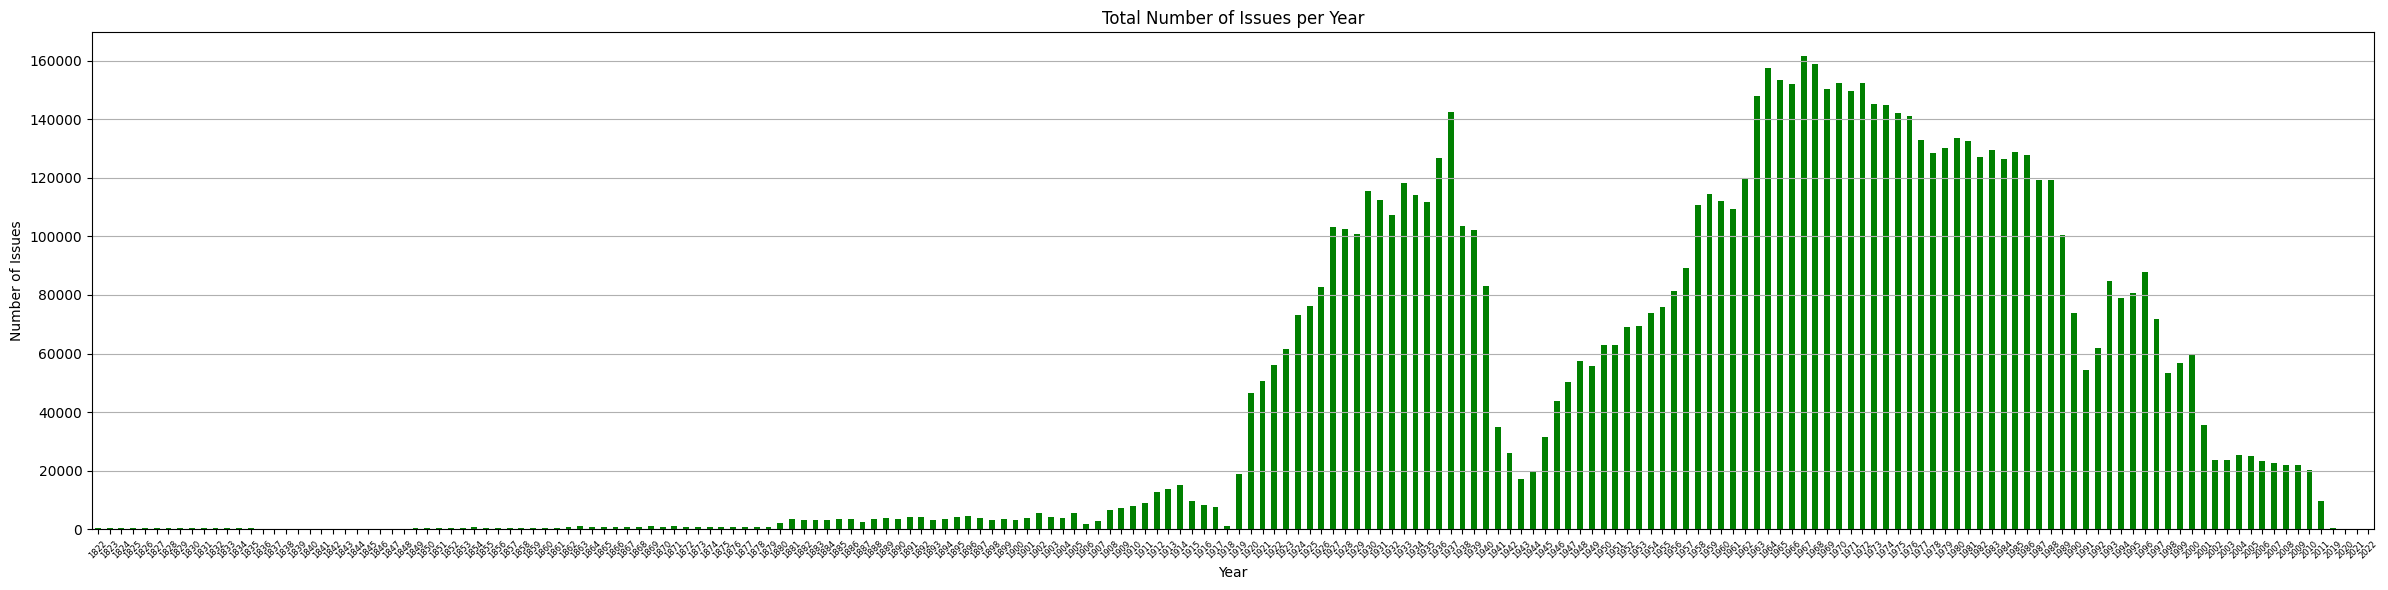

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Ensure the columns after the first 9 are year columns
year_columns = articles_df.columns[9:]  # Assuming the year columns start after the first 9 columns

# Check if the selected columns contain numeric data
print(f"Selected year columns: {year_columns}")  # Debugging step to verify selected columns
print(f"First row of year data: \n{articles_df[year_columns].head()}")  # Check the first few rows of selected columns

# Convert year columns to numeric, coerce errors to NaN
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Sum the issues per year (ignoring NaN)
issues_per_year = articles_df[year_columns].sum()

# Check if the issues_per_year series is empty
if issues_per_year.empty:
    print("No data available for plotting.")
else:
    # Plotting the bar chart
    plt.figure(figsize=(24, 6))
    issues_per_year.plot(kind='bar', color='green')
    plt.title('Total Number of Issues per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Issues')

    # Reduce font size for x-ticks (years)
    plt.xticks(rotation=45, fontsize=6)  # Adjust fontsize as needed

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


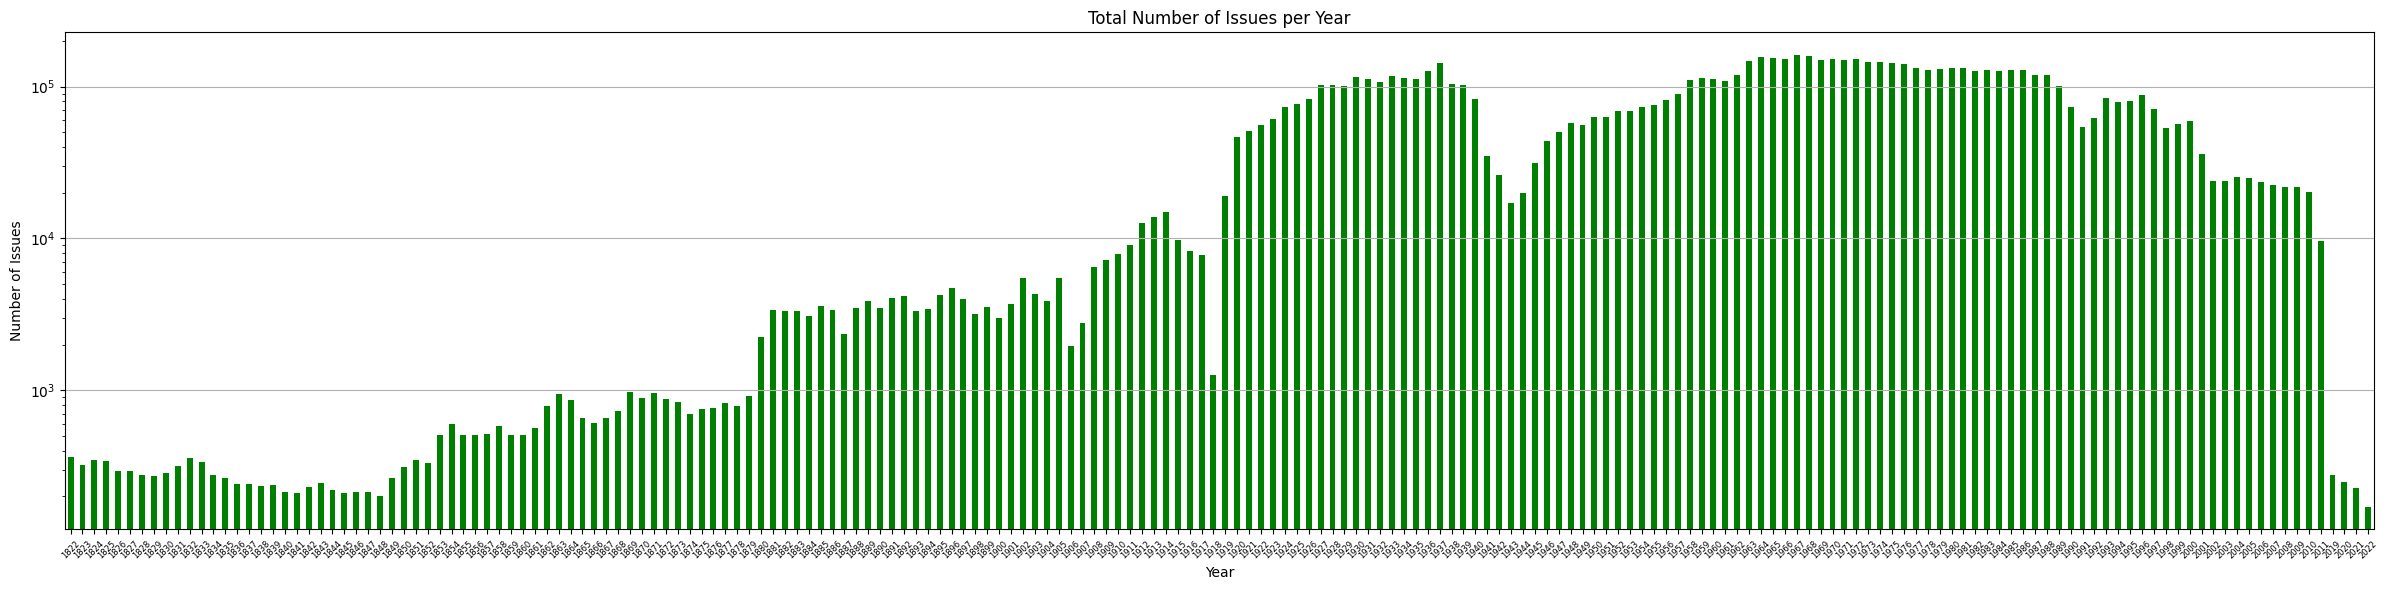

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Convert year columns to numeric, coerce errors to NaN
year_columns = articles_df.columns[9:]  # Assuming the year columns start after the first 9 columns
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Sum the issues per year excluding size columns
issues_per_year = articles_df[year_columns].sum()

# Plotting the bar chart
plt.figure(figsize=(24, 6))
issues_per_year.plot(kind='bar', color='green')
plt.title('Total Number of Issues per Year')
plt.xlabel('Year')
plt.ylabel('Number of Issues')

# Set logarithmic scale for y-axis
plt.yscale('log')

# Reduce font size for x-ticks (years)
plt.xticks(rotation=45, fontsize=6)  # Adjust fontsize as needed

plt.grid(axis='y')
plt.tight_layout()
plt.show()


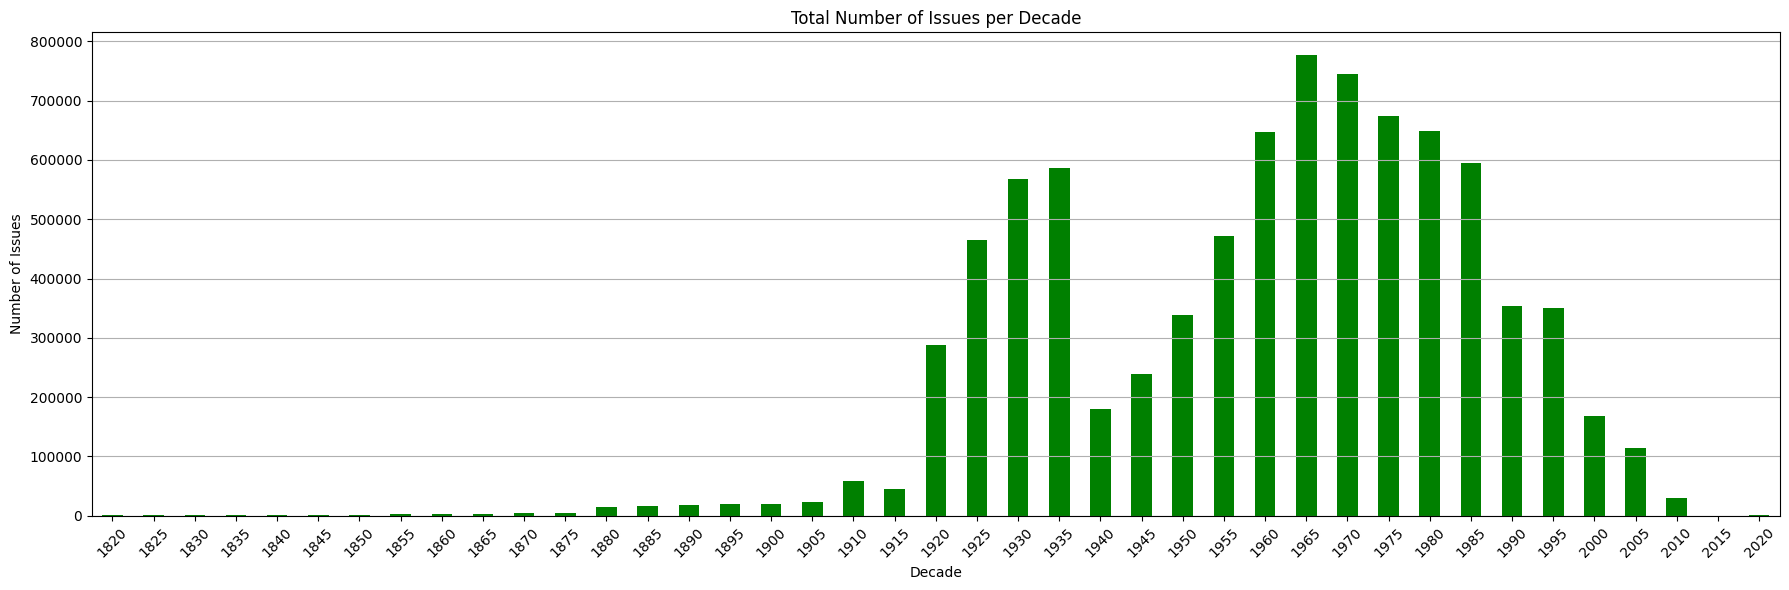

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Convert year columns to numeric, coercing errors to NaN
year_columns = articles_df.columns[9:]  # Adjust this based on your DataFrame structure
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Sum the issues per year
issues_per_year = articles_df[year_columns].sum()

# Group years into decades
issues_per_decade = issues_per_year.groupby((issues_per_year.index.astype(int) // 5) * 5).sum()

# Plotting the bar chart for decades
plt.figure(figsize=(18, 6))
issues_per_decade.plot(kind='bar', color='green')
plt.title('Total Number of Issues per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Issues')



# Reduce font size for x-ticks (decades)
plt.xticks(rotation=45, fontsize=10)  # Adjust fontsize as needed

plt.grid(axis='y')
plt.tight_layout()
plt.show()


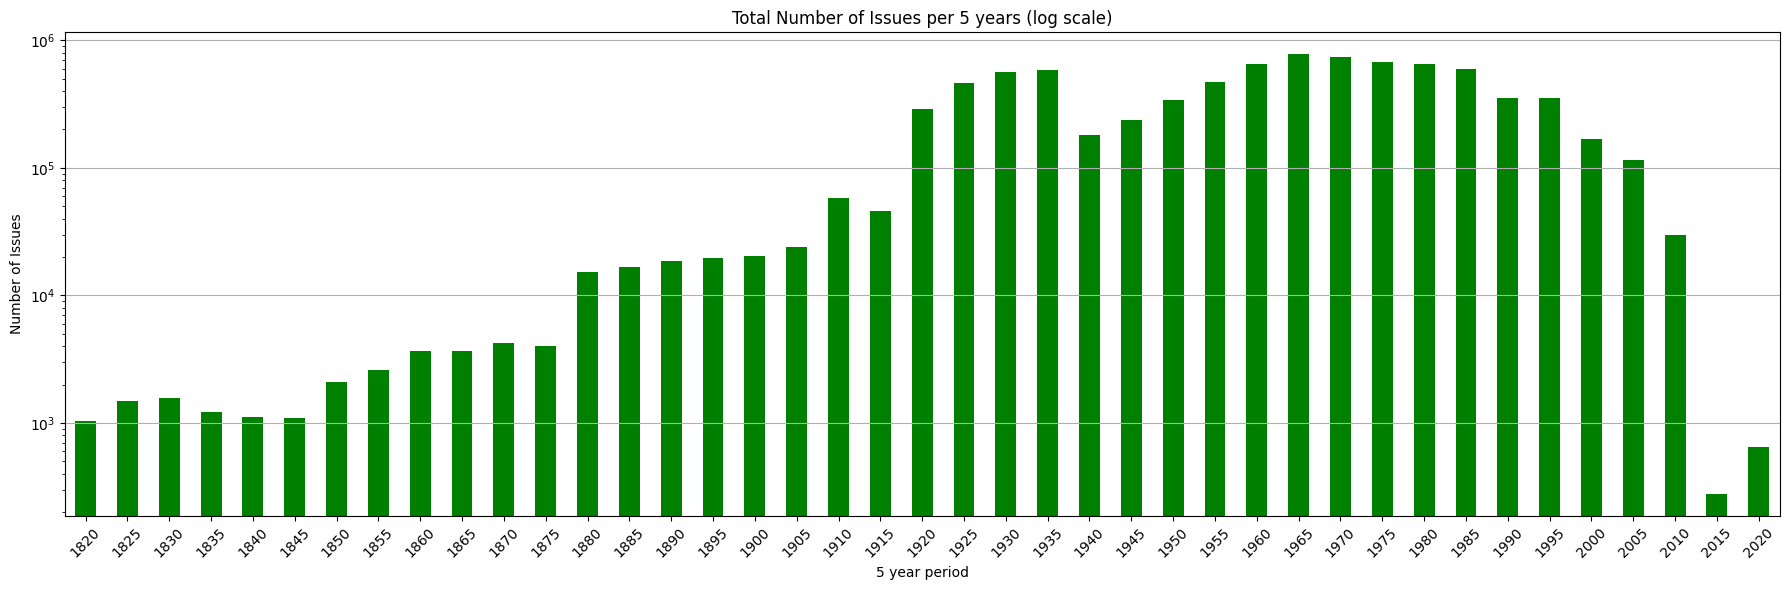

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Convert year columns to numeric, coercing errors to NaN
year_columns = articles_df.columns[9:]  # Adjust this based on your DataFrame structure
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Sum the issues per year
issues_per_year = articles_df[year_columns].sum()

# Group years into 5 years periods
issues_per_decade = issues_per_year.groupby((issues_per_year.index.astype(int) // 5) * 5).sum()

# Plotting the bar chart for 5 years periods
plt.figure(figsize=(18, 6))
issues_per_decade.plot(kind='bar', color='green')
plt.title('Total Number of Issues per 5 years (log scale)')
plt.xlabel('5 year period')
plt.ylabel('Number of Issues')

# Set logarithmic scale for y-axis
plt.yscale('log')

# Reduce font size for x-ticks

# Reduce font size for x-ticks (5 years per tick)
plt.xticks(rotation=45, fontsize=10)  # Adjust fontsize as needed

plt.grid(axis='y')
plt.tight_layout()
plt.show()


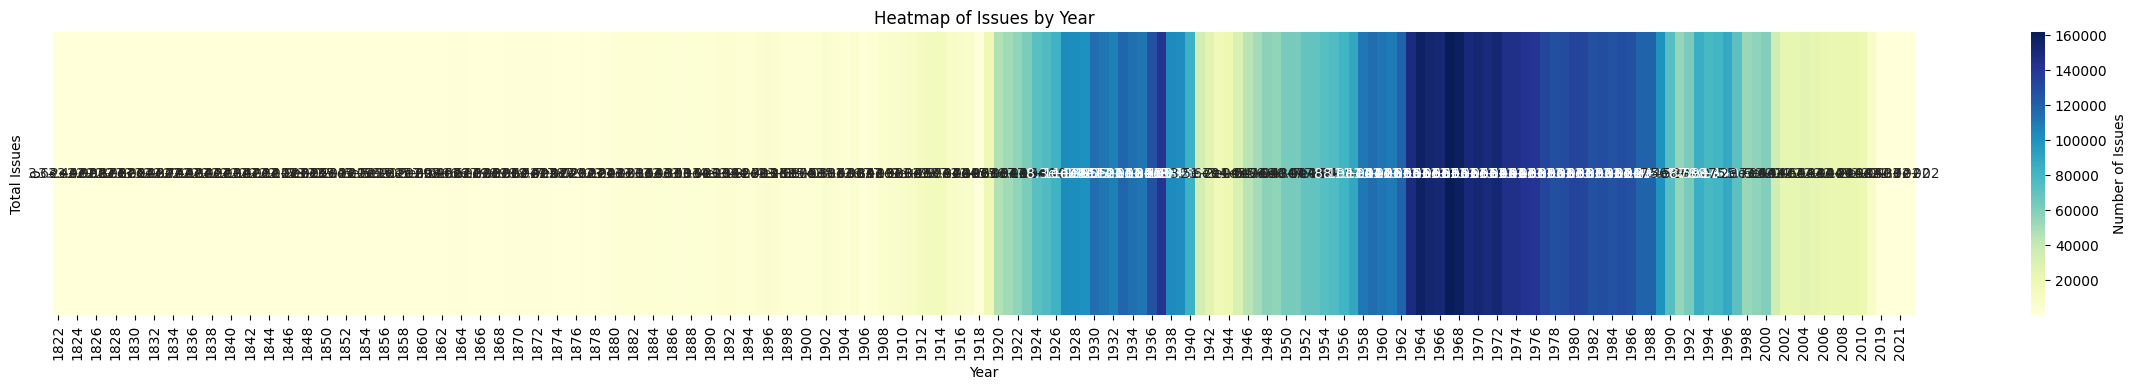

In [71]:
import seaborn as sns

# Sum the issues per year
issues_per_year = articles_df[year_columns].sum()

# Create a DataFrame for the heatmap
heatmap_data = pd.DataFrame(issues_per_year).transpose()

# Plotting the heatmap
plt.figure(figsize=(24, 4))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Number of Issues'})
plt.title('Heatmap of Issues by Year')
plt.xlabel('Year')
plt.ylabel('Total Issues')
plt.tight_layout()
plt.show()


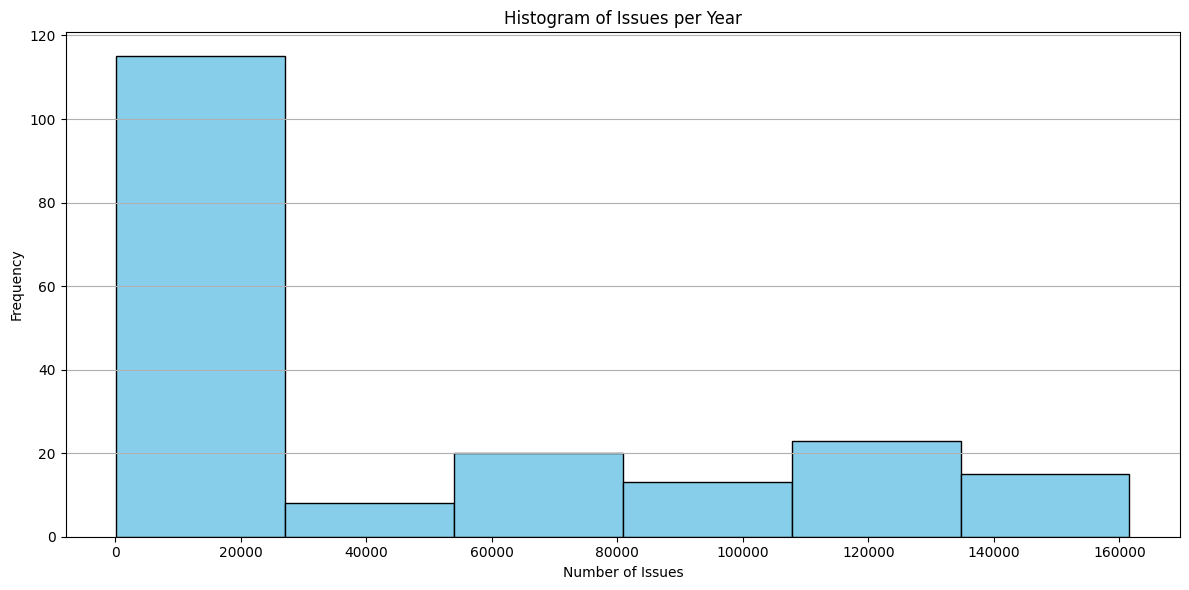

In [72]:
# Prepare data for histogram
issues_per_year = articles_df[year_columns].sum()

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(issues_per_year, bins=6, color='skyblue', edgecolor='black')
plt.title('Histogram of Issues per Year')
plt.xlabel('Number of Issues')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


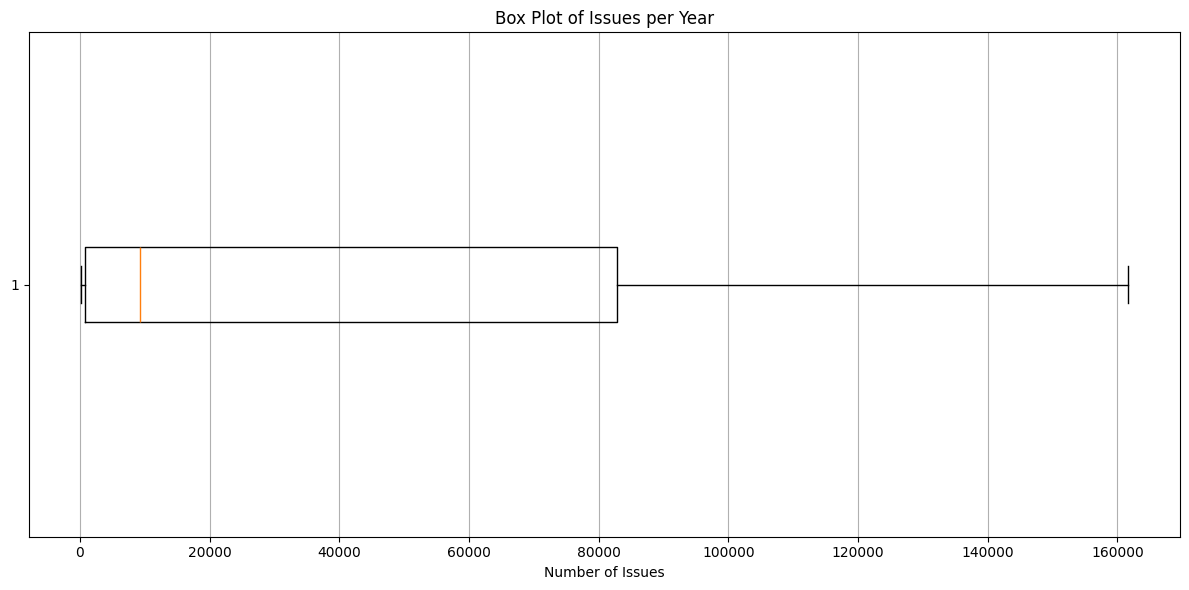

In [73]:

# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Convert year columns to numeric, coerce errors to NaN
year_columns = articles_df.columns[9:]  # Assuming the year columns start after the first 6 columns
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Prepare data for the box plot
issues_per_year = articles_df[year_columns].sum()

# Plotting the box plot
plt.figure(figsize=(12, 6))
plt.boxplot(issues_per_year, vert=False)
plt.title('Box Plot of Issues per Year')
plt.xlabel('Number of Issues')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


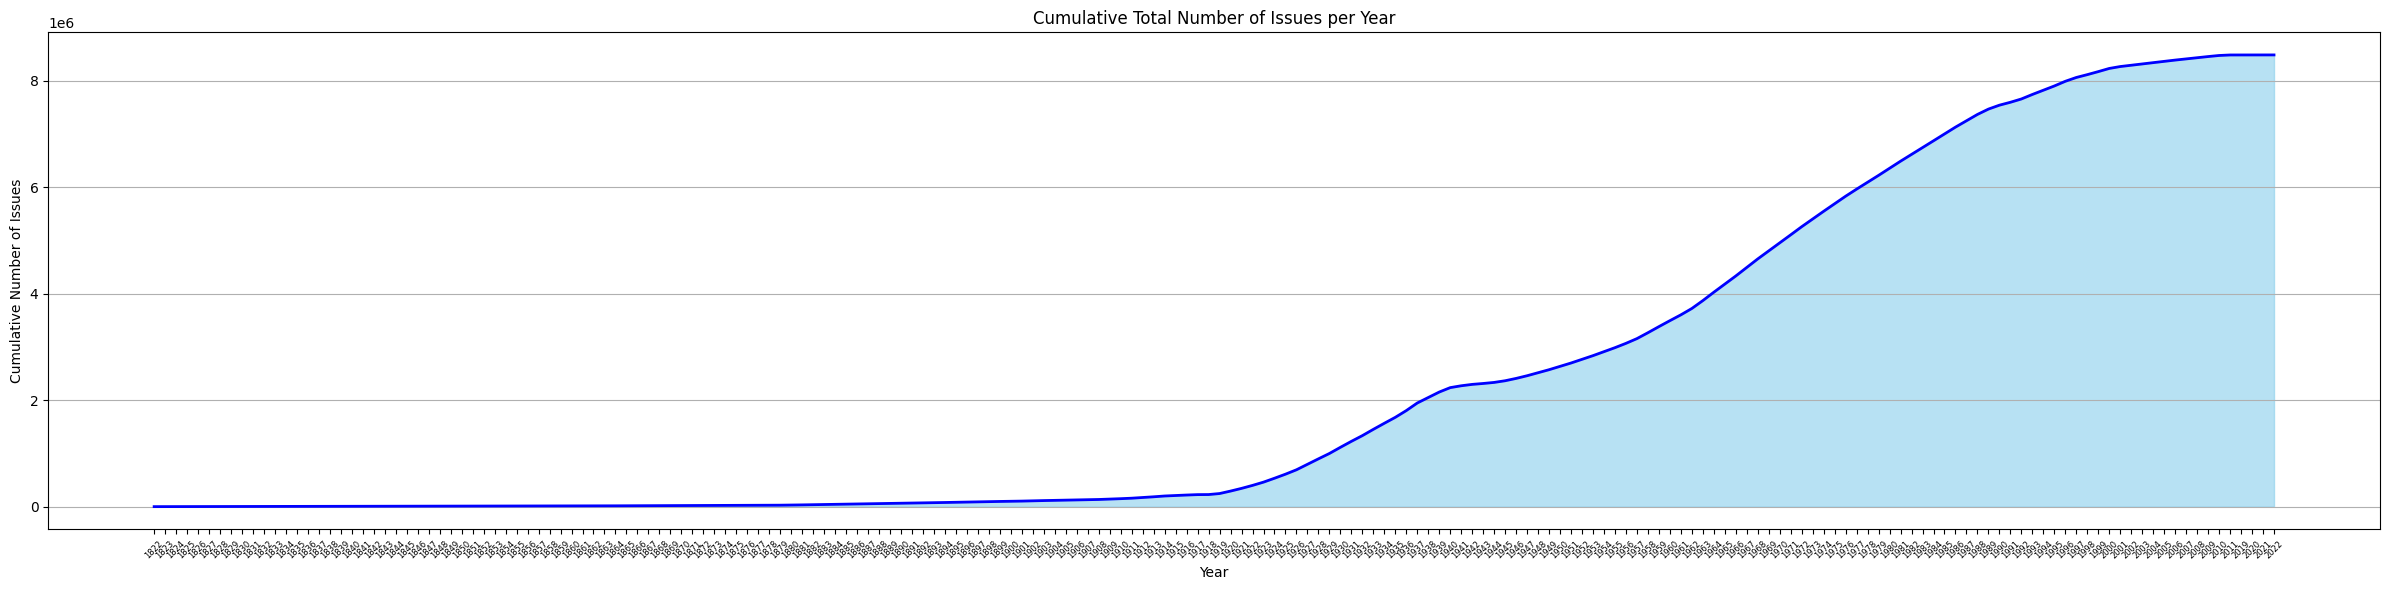

In [74]:

# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Convert year columns to numeric, coerce errors to NaN
year_columns = articles_df.columns[9:]  # Assuming the year columns start after the first 6 columns
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Sum the issues per year
issues_per_year = articles_df[year_columns].sum()

# Prepare data for area chart
years = issues_per_year.index  # Get years for x-axis
cumulative_issues = issues_per_year.cumsum()  # Calculate cumulative issues

# Plotting the area chart
plt.figure(figsize=(24, 6))
plt.fill_between(years, cumulative_issues, color='skyblue', alpha=0.6)
plt.plot(years, cumulative_issues, color='blue', linewidth=2)
plt.title('Cumulative Total Number of Issues per Year')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of Issues')

# Reduce font size for x-ticks
plt.xticks(rotation=45, fontsize=6)  # Adjust fontsize as needed

plt.grid(axis='y')
plt.tight_layout()
plt.show()


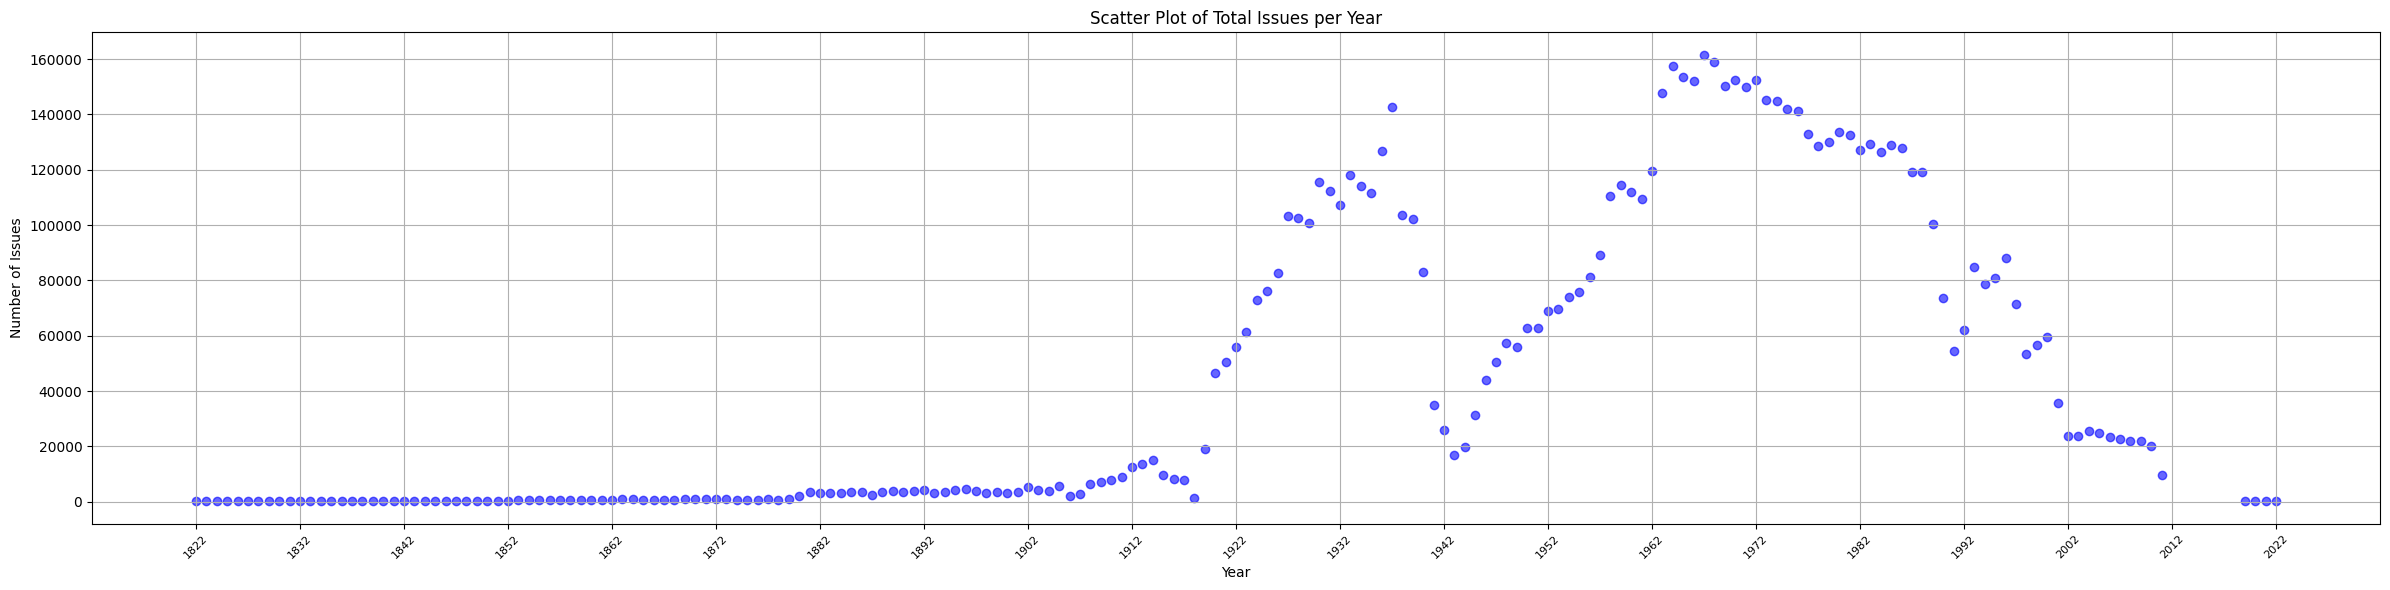

In [75]:
# Load the DataFrame from the CSV file
csv_file_path = r"I:\csv\zip_article_stats.csv"
articles_df = pd.read_csv(csv_file_path, sep=';', encoding='utf-8-sig')

# Convert year columns to numeric, coerce errors to NaN
year_columns = articles_df.columns[9:]  # Assuming the year columns start after the first 9 columns
articles_df[year_columns] = articles_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Prepare data for scatter plot
issues_per_year = articles_df[year_columns].sum()  # Summing the issues for each year
years = issues_per_year.index.astype(int)  # Getting the years as integers
issues = issues_per_year.values  # Getting the number of issues as values

# Plotting the scatter plot
plt.figure(figsize=(24, 6))
plt.scatter(years, issues, color='blue', alpha=0.6)  # Scatter plot
plt.title('Scatter Plot of Total Issues per Year')
plt.xlabel('Year')
plt.ylabel('Number of Issues')

# Set 10-year intervals on the x-axis
min_year = years.min()
max_year = years.max()
plt.xticks(ticks=range(min_year, max_year + 1, 10), rotation=45, fontsize=8)  # Adjusting font size

plt.grid(True)
plt.tight_layout()
plt.show()